In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from src.preprocessing.process_sounds_metadata import generate_sounds_metadata, make_fixed_size_sounds
from src.preprocessing.filters import filter_recs_metadata
from src.preprocessing.load_data import load_recs_dict, load_sounds
from src.deep_learning.create_model import create_conv_model
from src.data_representations.process_wavs import *
from src.data_representations.process_images import *
from src.deep_learning.vae import VAE
import torch
from torch.utils.data import DataLoader
from src.preprocessing.load_data import *
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended

%matplotlib inline


In [2]:
colonies = ['baratheon', 'dothrakib', 'martell','targaryen']
dates = 'all'
experiments = ['single rat softchirps','baratheon epochs']
stages = ['traced and checked']
experiments = 'all'
sr = 22050

In [3]:
path_to_recordings_metadata = PATH_TO_PROJECT + '/data/recordings_metadata_old_backup.csv'
recs_metadata = pd.read_csv(path_to_recordings_metadata)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_for_training = recs_metadata[mask]
recs_dict = load_recs_dict(recs_for_training)
sounds_metadata_raw = generate_sounds_metadata(recs_for_training).reset_index(drop=True)

/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [4]:
classes_to_plot = ['softchirp', ]
sounds_metadata = sounds_metadata_raw[sounds_metadata_raw['cl'].isin(classes_to_plot)].reset_index(drop=True)
sounds_metadata['s'] = sounds_metadata['s'].apply(lambda x: int(sr * x))
sounds_metadata['e'] = sounds_metadata['e'].apply(lambda x: int(sr * x))

info = load_info_file(PATH_TO_PROJECT + 'data/rat_info.csv')
sounds_metadata_extended = extend_sounds_metadata(sounds_metadata, info)

print(sounds_metadata_extended.shape)
sounds_metadata_extended.head()

No info for 9466
No info for 2159
No info for 2041
No info for 4020
No info for 4012
No info for 3900
No info for 4018
No info for 4202
No info for 3914
No info for 4006
No info for 4065
No info for 4063
No info for 4023
No info for 3902
(25503, 15)


,s,e,cl,rec,colony,ratids,date,experiment,weight,sex,rank,dob,age,bodylength,bodylength2
0,769136,771027,softchirp,baratheon_21-06-19_9449_0000001.npy,baratheon,9449,21-06-19,single rat softchirps,51.4,M,rank4,30.04.13,2243.0,150.0,115.0
1,809371,811852,softchirp,baratheon_21-06-19_9449_0000001.npy,baratheon,9449,21-06-19,single rat softchirps,51.4,M,rank4,30.04.13,2243.0,150.0,115.0
2,856096,857544,softchirp,baratheon_21-06-19_9449_0000001.npy,baratheon,9449,21-06-19,single rat softchirps,51.4,M,rank4,30.04.13,2243.0,150.0,115.0
3,955251,960244,softchirp,baratheon_21-06-19_9449_0000001.npy,baratheon,9449,21-06-19,single rat softchirps,51.4,M,rank4,30.04.13,2243.0,150.0,115.0
4,999936,1004070,softchirp,baratheon_21-06-19_9449_0000001.npy,baratheon,9449,21-06-19,single rat softchirps,51.4,M,rank4,30.04.13,2243.0,150.0,115.0


In [5]:
p = {'num_freq_bins': 128,
     'num_time_bins': 128,
     'nperseg': 512, 
     'noverlap': 256, # FF
     'min_freq': 2000,
     'max_freq': 10000,
     'spec_min_val': -15, 
     'spec_max_val': 0}

spec_train_aug = extract_specs_new(sounds_metadata, recs_dict, p, sr=22050)

In [6]:
data = [torch.from_numpy(S, ).cuda().float() for S in spec_train_aug]
dl = DataLoader(data, batch_size=1, shuffle=False, sampler=None,)

model = VAE(save_dir='.', lr=6e-4, z_dim=32, model_precision=10.0, device_name="auto")
model.load_state('vae_7classes')

latent_features = pd.DataFrame(model.get_latent(dl))

In [7]:
from datetime import datetime
# It is possible here to compute date masks for each colony separately. If you don't want to use these masks, 
# set variable "separate_colonies_dates" to False in the cell below
func_to_dt = lambda x : datetime(*reversed(list(map(int, x.replace('-', '.').split('.')))))
dates_per_colony = {'baratheon' : ['24-03-19', '03-11-19'],
                    'martell':['24-03-19', '01-12-19'],
                    'targaryen':['24-03-19', '03-11-19'],
                    'dothrakib':['24-03-19', '03-11-19']}

separate_date_masks = np.zeros(len(sounds_metadata_extended), dtype='bool')

dates_transformed = sounds_metadata_extended['date'].apply(func_to_dt)
mask_dates_per_colony = np.ones(sounds_metadata_extended.shape[0], dtype='bool')
for col, (d_min, d_max) in dates_per_colony.items():
    d_min, d_max = func_to_dt(d_min), func_to_dt(d_max)
    col_mask_d = dates_transformed.apply(lambda x: d_min <= x <= d_max) & (sounds_metadata_extended['colony']
                                                                           == col)
    separate_date_masks = separate_date_masks | col_mask_d 

Keys:  ['s', 'e', 'cl', 'rec', 'colony', 'ratids', 'date', 'experiment', 'weight', 'sex', 'rank', 'dob', 'age', 'bodylength', 'bodylength2']
Average accuracy is 0.49
Accuracy on foster pups is 0.78

FOSTER 3481:
Accuracy is 0.870
Colony baratheon with probability 0.28
Predicted colony baratheon for 16 out of 123 softchirps
Colony dothrakib with probability 0.05
Predicted colony dothrakib for 0 out of 123 softchirps
Colony martell with probability 0.60
Predicted colony martell for 107 out of 123 softchirps
Colony targaryen with probability 0.07
Predicted colony targaryen for 0 out of 123 softchirps

FOSTER 4057:
Accuracy is 0.811
Colony baratheon with probability 0.23
Predicted colony baratheon for 46 out of 396 softchirps
Colony dothrakib with probability 0.11
Predicted colony dothrakib for 8 out of 396 softchirps
Colony martell with probability 0.15
Predicted colony martell for 21 out of 396 softchirps
Colony targaryen with probability 0.51
Predicted colony targaryen for 321 out of 39

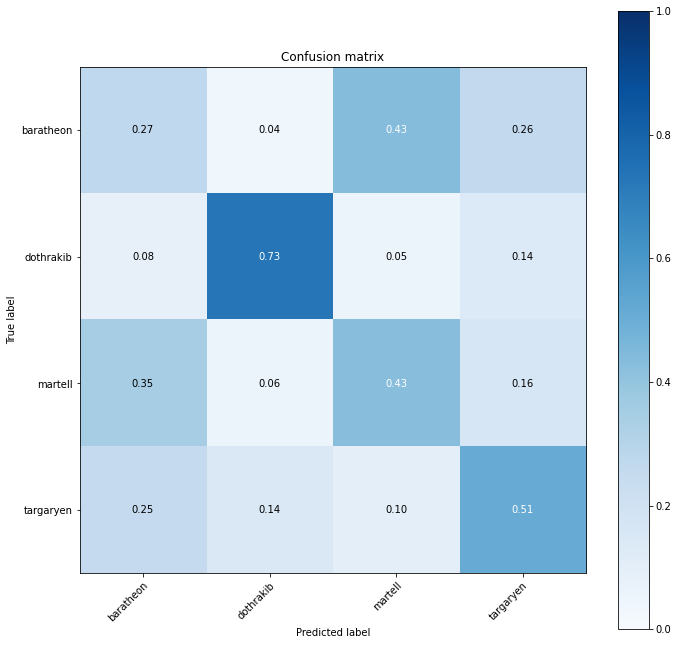

In [10]:
from src.data_analysis.softchirps_classification import classify, make_bins



# # what data to use, specify here 
metadata = sounds_metadata_extended
features = latent_features
print('Keys: ', list(metadata.columns))
colonies = ['baratheon','dothrakib', 'martell', 'targaryen']
#colonies that specified here are used to train classifer
weights = 'all'
dates = 'all'
separate_colonies_dates = False
sexes = 'all' # options:('M'), ('F'), 'all'
ages = 'all' # options: [180, np.inf], in days
ages_foster = (180, np.inf) # specifies ages of foster pups
ranks = 'all' # options: ('rank1', 'rank2', 'rank3', 'rank4', 'rank5')
ratids = 'all' # can specify indivudals here
bodylengths = 'all' # options: (0, np.inf), all # snout to tail length measured
bodylengths2 ='all' # options: (0, np.inf), all # snout to rump length measured

foster_ids = ['4057', '4075', '3523', '3481', '3513']
#4075= daenerys, 4057 = johnsnown, 3523= missandei, 3481 = obara, 3512 = nymeria
exclude_rats = [] # option to exclude individuals here
sounds_per_rat = [20, 1000]
#'single', 'pairs', 'all'
types = 'single'

features_to_classify = 'all'
classify_by = 'colony'
#classify_by options: 'ratids', 'colony', 'epoch'
group_by = 'ratids' #'ratids' #None, 'ratids', 'date' #specifies how training and test data is split
#NB: you must group by 'ratids' when testing colony dialect 
balance = True #balances number of soft chirps across classes
cv_n_folds = 3 #more cross-validation (c-v) folds are generally better
analyse_fosters = True
#set analyse_fosters = False; when testing for rank, sex, ratids, body-length, weight
#cmap options: plt.cm.Blues, plt.cm.Purples, plt.cm.Oranges, plt.cm.Reds, plt.cm.OrRd
cmap = plt.cm.Blues


order = ORDER[classify_by]
#specifies order of classes and colors that plotted
color = COLOR[classify_by]
color_dict = COLOR[classify_by]



mask =  filter_sounds_metadata_extended(metadata, ratids, foster_ids + exclude_rats, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
if separate_colonies_dates:
    mask = mask & separate_date_masks
    
foster_colonies = 'all'
# if you want to change other filters for foster, hust change values in the function call below
mask_foster = filter_sounds_metadata_extended(metadata, foster_ids,
                                         None, types, foster_colonies, weights, sexes, ages_foster, ranks, dates,
                                         bodylengths, bodylengths2, 'all')
#set = to True here for binning of weights, body lengths for classifer (first) or group_by (second) 
if False:  # BINNING OF CLASSIFY COLUMN
    binsize = 10
    mask_index = metadata[mask].index
    metadata.loc[mask_index, classify_by] = make_bins(metadata[mask][classify_by], binsize)
if False:  # BINNING OF GROUP COLUMN
    binsize = 10 
    metadata[mask][group_by] = make_bins(metadata[mask][group_by], binsize)
    
print_info = False
clf, foster_probs, y_unique, y_unique_foster = classify(features, metadata, mask, mask_foster, 
                                                        order, classify_by,  features_to_classify, group_by,
                                                        balance, cv_n_folds, analyse_fosters, print_info, cmap)
print('\nFeatures importances:', )
for fn, fimp in zip(features_to_classify, clf.feature_importances_):
    print('%s: %.3f' % (fn, fimp))

if analyse_fosters:
    prediction = clf.predict_proba(features[mask_foster])
    prediction = np.concatenate([prediction, 
                                 np.zeros((len(prediction), len(y_unique_foster) - len(y_unique)))], 1)
    foster_predictions = pd.DataFrame(prediction, columns = y_unique_foster)
    foster_predictions['ratids'] = metadata[mask_foster]['ratids'].reset_index(drop = True)
    foster_predictions['age'] = metadata[mask_foster]['age'].reset_index(drop = True)
plt.savefig("test.svg", format="svg")